Assignment 3

Name: Wenxin Li

Student ID: 1007508724

All the answers to the below questions are in this file.

In [0]:
#pip install pyspark-dist-explore

In [0]:
#all spark imports
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import desc
from pyspark.sql.functions import col
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import pyspark.sql.functions as F
import urllib.request
import matplotlib.pyplot as plt
import pandas as pd

from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
#from pyspark_dist_explore import hist

# Assignment 3

In [0]:
#instantiate the spark session
spark = SparkSession.builder.appName("Demo").getOrCreate()

## Part A

### Q1

Intrusion detection system (IDS) is a system that monitors and analyzes data to detect any intrusion in the system or network. 

10% subset of KDD Cup 99 data has 41 different features and 494021 samples. Intrusion Detection System can be implemented on this dataset, but it need to use Big Data tools(Spark) and techniques(such as SVM) to analyze and store data to reduce computation and training time.

The workflow in this paper can be split into three parts. First, loading and preprocessing the data by change the type of data, encoding, and standardize the features. Second, select the features which are highly relevant to the target and get rid of the irrelevant features by Chi Squared test. This can help reduce the processing time of model training. Third, they split the data into a training set and a test set. They use the training set to train the SVM model and check the performance of the model by the prediction error of the model on the test set.

### Q2

In [0]:
urllib.request.urlretrieve("http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz", "/tmp/kddcup_data.gz")
dbutils.fs.mv("file:/tmp/kddcup_data.gz", "dbfs:/kdd/kddcup_data.gz")
display(dbutils.fs.ls("dbfs:/kdd"))

path,name,size
dbfs:/kdd/kddcup_data.gz,kddcup_data.gz,2144903


### Q3

In [0]:
cupRDD = spark.sparkContext.textFile('dbfs:/kdd/kddcup_data.gz')

In [0]:
cupRDD.take(10)

Out[106]: ['0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,19,19,1.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,29,29,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,39,39,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,49,49,1.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,59,59,1.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,212,1940,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2,0.00,0.00,0.00,0.00,1.00,0.00,1.00,1,69,1.00,0.00,1.00,0.04,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,159,4087,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.00,0.00,0.00,0.00,1.00,0.00,0.00,11,79,1.00,0.00,0.09,0.04,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,210,151,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,8,89,1.00,0.00,0.12,0.04,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,212,786,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,8,99,1.00,0.00,0.12,0.05,0.00,0.00,0.00,0.00,normal.']

The rdd data is a list of strings. Each string is all the features and target(label) of one sample and each feature split by comma.

### Q4

In [0]:
df = cupRDD.map(lambda x: x.split(",")).toDF()

In [0]:
print('Total number of features:',len(df.columns))

Total number of features: 42

In [0]:
display(df)

_1,_2,_3,_4,_5,_6,_7,_8,_9,_10,_11,_12,_13,_14,_15,_16,_17,_18,_19,_20,_21,_22,_23,_24,_25,_26,_27,_28,_29,_30,_31,_32,_33,_34,_35,_36,_37,_38,_39,_40,_41,_42
0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.
0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,19,19,1.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,normal.
0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,29,29,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.
0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,39,39,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.
0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,49,49,1.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,normal.
0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,59,59,1.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,normal.
0,tcp,http,SF,212,1940,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2,0.00,0.00,0.00,0.00,1.00,0.00,1.00,1,69,1.00,0.00,1.00,0.04,0.00,0.00,0.00,0.00,normal.
0,tcp,http,SF,159,4087,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.00,0.00,0.00,0.00,1.00,0.00,0.00,11,79,1.00,0.00,0.09,0.04,0.00,0.00,0.00,0.00,normal.
0,tcp,http,SF,210,151,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,8,89,1.00,0.00,0.12,0.04,0.00,0.00,0.00,0.00,normal.
0,tcp,http,SF,212,786,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,8,99,1.00,0.00,0.12,0.05,0.00,0.00,0.00,0.00,normal.


### Q5

In [0]:
newRDD = cupRDD.map(lambda x: x.split(",")).map(lambda x: x[0:6]+x[-1:])

In [0]:
newRDD.take(10)

Out[111]: [['0', 'tcp', 'http', 'SF', '181', '5450', 'normal.'],
 ['0', 'tcp', 'http', 'SF', '239', '486', 'normal.'],
 ['0', 'tcp', 'http', 'SF', '235', '1337', 'normal.'],
 ['0', 'tcp', 'http', 'SF', '219', '1337', 'normal.'],
 ['0', 'tcp', 'http', 'SF', '217', '2032', 'normal.'],
 ['0', 'tcp', 'http', 'SF', '217', '2032', 'normal.'],
 ['0', 'tcp', 'http', 'SF', '212', '1940', 'normal.'],
 ['0', 'tcp', 'http', 'SF', '159', '4087', 'normal.'],
 ['0', 'tcp', 'http', 'SF', '210', '151', 'normal.'],
 ['0', 'tcp', 'http', 'SF', '212', '786', 'normal.']]

In [0]:
column_name =['Duration','Protocol_type','Service','Flag','Src_bytes','Dst_bytes','Label']

In [0]:
newdf = newRDD.toDF(column_name)

In [0]:
newdf.printSchema()

root
-- Duration: string (nullable = true)
-- Protocol_type: string (nullable = true)
-- Service: string (nullable = true)
-- Flag: string (nullable = true)
-- Src_bytes: string (nullable = true)
-- Dst_bytes: string (nullable = true)
-- Label: string (nullable = true)

In [0]:
newdf = newdf.withColumn('Duration',newdf.Duration.cast('int')).withColumn('Src_bytes',newdf.Src_bytes.cast('int')).withColumn('Dst_bytes',newdf.Dst_bytes.cast('int'))

In [0]:
newdf.printSchema()

root
-- Duration: integer (nullable = true)
-- Protocol_type: string (nullable = true)
-- Service: string (nullable = true)
-- Flag: string (nullable = true)
-- Src_bytes: integer (nullable = true)
-- Dst_bytes: integer (nullable = true)
-- Label: string (nullable = true)

In [0]:
display(newdf.limit(10))

Duration,Protocol_type,Service,Flag,Src_bytes,Dst_bytes,Label
0,tcp,http,SF,181,5450,normal.
0,tcp,http,SF,239,486,normal.
0,tcp,http,SF,235,1337,normal.
0,tcp,http,SF,219,1337,normal.
0,tcp,http,SF,217,2032,normal.
0,tcp,http,SF,217,2032,normal.
0,tcp,http,SF,212,1940,normal.
0,tcp,http,SF,159,4087,normal.
0,tcp,http,SF,210,151,normal.
0,tcp,http,SF,212,786,normal.


### Q6

In [0]:
def get_type_count_value(collectedData):
    col_type = []
    col_count = []
    for i in collectedData:
        col_type.append(i[0])    
        col_count.append(i[1]) 
    return col_type,col_count

In [0]:
newdf.groupBy('Protocol_type').count().sort('count').show()

+-------------+------+
Protocol_type| count|
+-------------+------+
 udp| 20354|
 tcp|190065|
 icmp|283602|
+-------------+------+

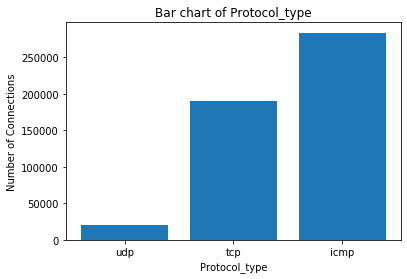

In [0]:
proto = newdf.groupBy('Protocol_type').count().sort('count').collect()
Proto_type, Proto_count = get_type_count_value(proto)
plt.bar(Proto_type, Proto_count)
plt.xlabel('Protocol_type')
plt.ylabel('Number of Connections')
plt.title('Bar chart of Protocol_type')
plt.show()

In [0]:
newdf.groupBy('Service').count().sort('count').show()

+-----------+-----+
 Service|count|
+-----------+-----+
 red_i| 1|
 pm_dump| 1|
 tftp_u| 1|
 tim_i| 7|
 X11| 11|
 urh_i| 14|
 IRC| 43|
 Z39_50| 92|
 netstat| 95|
 ctf| 97|
 kshell| 98|
 name| 98|
netbios_dgm| 99|
 http_443| 99|
 exec| 99|
 ldap| 101|
 pop_2| 101|
 link| 102|
 netbios_ns| 102|
 daytime| 103|
+-----------+-----+
only showing top 20 rows

In [0]:
newdf.groupBy('Service').count().sort('count').display()

Service,count
tftp_u,1
red_i,1
pm_dump,1
tim_i,7
X11,11
urh_i,14
IRC,43
Z39_50,92
netstat,95
ctf,97


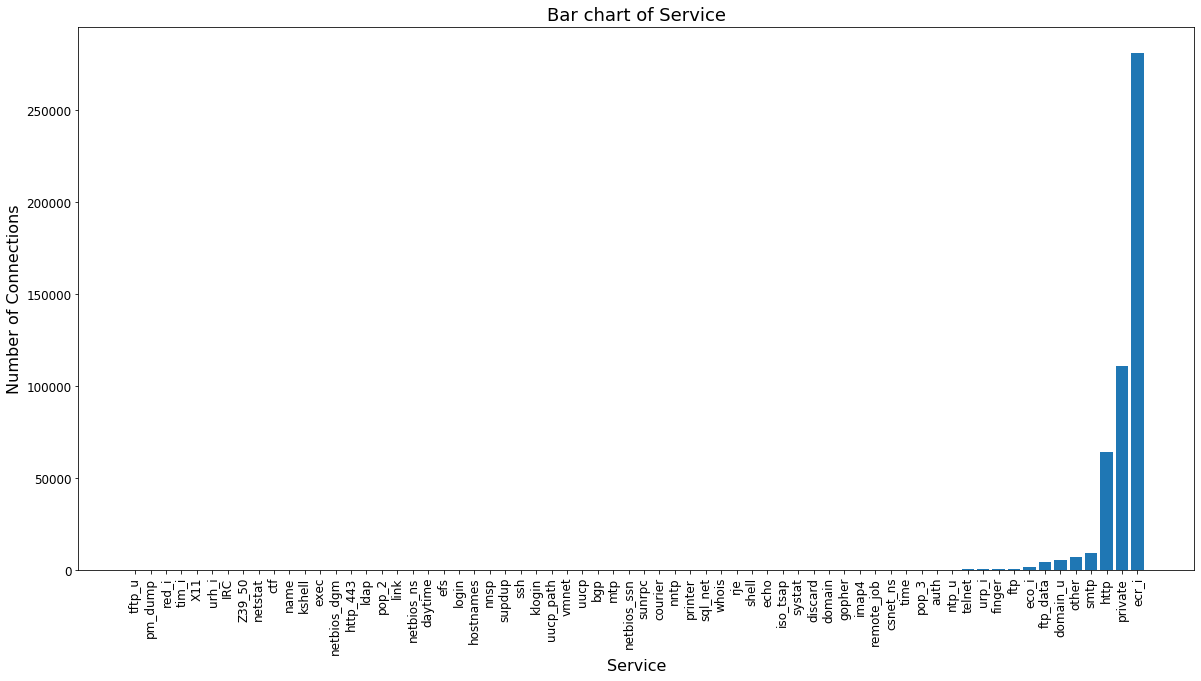

In [0]:
service = newdf.groupBy('Service').count().sort('count').collect()
Service_type,Service_count = get_type_count_value(service)
plt.figure(figsize=(20,10))
plt.bar(Service_type,Service_count)
plt.xlabel('Service',fontsize=16)
plt.ylabel('Number of Connections',fontsize=16)
plt.title('Bar chart of Service',fontsize=18)
plt.xticks(rotation=90,fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Q7

In [0]:
newdf.groupBy('Label').count().sort('count').show()

+----------------+-----+
 Label|count|
+----------------+-----+
 spy.| 2|
 perl.| 3|
 phf.| 4|
 multihop.| 7|
 ftp_write.| 8|
 loadmodule.| 9|
 rootkit.| 10|
 imap.| 12|
 warezmaster.| 20|
 land.| 21|
buffer_overflow.| 30|
 guess_passwd.| 53|
 nmap.| 231|
 pod.| 264|
 teardrop.| 979|
 warezclient.| 1020|
 portsweep.| 1040|
 ipsweep.| 1247|
 satan.| 1589|
 back.| 2203|
+----------------+-----+
only showing top 20 rows

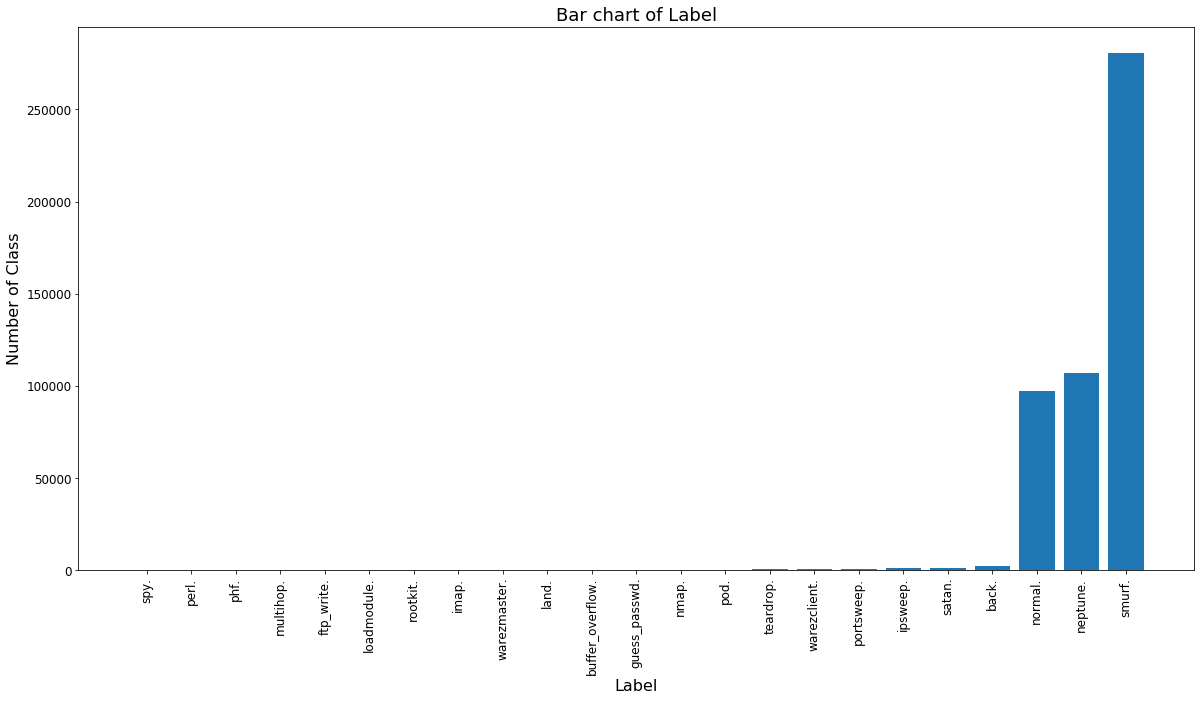

In [0]:
#plot 1: Bar chart
label = newdf.groupBy('Label').count().sort('count').collect()
Label_type,Label_count = get_type_count_value(label)
plt.figure(figsize=(20,10))
plt.bar(Label_type,Label_count)
plt.xlabel('Label',fontsize=16)
plt.ylabel('Number of Class',fontsize=16)
plt.title('Bar chart of Label',fontsize=18)
plt.xticks(rotation=90,fontsize=12)
plt.yticks(fontsize=12)
plt.show()

The bar chart of labels shows that there are multiple labels in these datasets, with the three most frequent labels being Smurf, Neptune, and Normal.

In [0]:
duration = newdf.select('Duration').rdd.flatMap(lambda x: x).histogram(5)

In [0]:
duration

Out[127]: ([0.0, 11665.8, 23331.6, 34997.399999999994, 46663.2, 58329],
 [493536, 430, 36, 18, 1])

In [0]:
freq_duration = pd.DataFrame(list(zip(*duration)), columns=['bin', 'frequency'])

In [0]:
freq_duration.bin = freq_duration.bin.values.astype('int')

In [0]:
freq_duration

,bin,frequency
0,0,493536
1,11665,430
2,23331,36
3,34997,18
4,46663,1


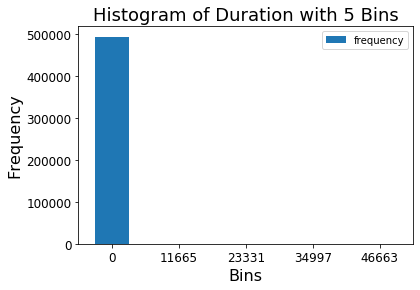

In [0]:
#Plot 2: Histogram chart
freq_duration.set_index('bin').plot(kind='bar')
plt.xlabel('Bins',fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.title('Histogram of Duration with 5 Bins',fontsize=18)
plt.xticks(rotation=0,fontsize=12)
plt.yticks(fontsize=12)
plt.show()

The frequency histogram of the duration shows that most of the connection lengths have a frequency equal to 0 seconds. The percentage of durations longer than 10,000 seconds is 99.9% higher, and only 50 samples are larger than 20,000 seconds.

In [0]:
two_bytes = newdf.select('Src_bytes','Dst_bytes').toPandas()

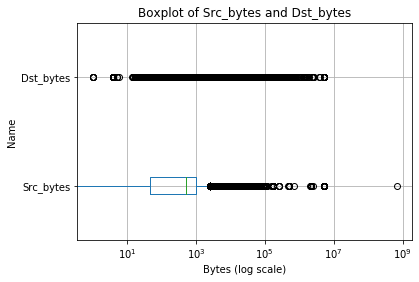

In [0]:
#Plot 3: Boxplot of Src_bytes and Dst_bytes
two_bytes.boxplot(vert=False)
plt.xscale('log')
plt.xlabel('Bytes (log scale)')
plt.ylabel('Name')
plt.title('Boxplot of Src_bytes and Dst_bytes')
plt.show()

In this boxplot, the distribution of the Dst_bytes is spread between 10 to 10e7 and there are onlt few samples' Dst_bytes are lower than 10 bytes. Opposite, the samples of the Src_bytes concentrate at the 100 to 1000 bytes level. Besides, another big clusters of Src_bytes concentrate at 10e4-1oe5 bytes lavel, and only one sample at 10e9 which can be seen as a outlier. The distribution of Dst_bytes is wider than the distribution of Src_bytes.

### Q8

In [0]:
# create a newLabel column (attack=1,normal=0)
def check_label(value):
    if   value != 'normal.': 
        return 1
    else:
        return 0

udfsomefunc = F.udf(check_label, IntegerType())
newdf = newdf.withColumn("newLabel", udfsomefunc("Label"))
display(newdf.limit(10))

Duration,Protocol_type,Service,Flag,Src_bytes,Dst_bytes,Label,newLabel
0,tcp,http,SF,181,5450,normal.,0
0,tcp,http,SF,239,486,normal.,0
0,tcp,http,SF,235,1337,normal.,0
0,tcp,http,SF,219,1337,normal.,0
0,tcp,http,SF,217,2032,normal.,0
0,tcp,http,SF,217,2032,normal.,0
0,tcp,http,SF,212,1940,normal.,0
0,tcp,http,SF,159,4087,normal.,0
0,tcp,http,SF,210,151,normal.,0
0,tcp,http,SF,212,786,normal.,0


In [0]:
(train, test) = newdf.randomSplit([0.8, 0.2],seed=2022)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 395165
Test Dataset Count: 98856

In [0]:
num_cols = [ 'Duration',  'Src_bytes','Dst_bytes']
cat_cols = ['Protocol_type', 'Service', 'Flag']
label_col = 'newLabel'

In [0]:
input_cols = num_cols

In [0]:
stages = []
for col in cat_cols:
    string_indexer = StringIndexer(inputCol=col, outputCol=col + "Index")
    stages += [string_indexer]
    input_cols.append(col + "Index")

In [0]:
stages

Out[139]: [StringIndexer_38a153e97f10,
 StringIndexer_8cb183db884d,
 StringIndexer_9767589046ea]

In [0]:
vect_assembler = VectorAssembler(inputCols= input_cols, outputCol="features")
stages += [vect_assembler]

In [0]:
pipeline = Pipeline().setStages(stages)
pipeline_model = pipeline.fit(newdf)
train_df = pipeline_model.transform(newdf)

In [0]:
display(train_df)

Duration,Protocol_type,Service,Flag,Src_bytes,Dst_bytes,Label,newLabel,Protocol_typeIndex,ServiceIndex,FlagIndex,features
0,tcp,http,SF,181,5450,normal.,0,1.0,2.0,0.0,"List(1, 6, List(), List(0.0, 181.0, 5450.0, 1.0, 2.0, 0.0))"
0,tcp,http,SF,239,486,normal.,0,1.0,2.0,0.0,"List(1, 6, List(), List(0.0, 239.0, 486.0, 1.0, 2.0, 0.0))"
0,tcp,http,SF,235,1337,normal.,0,1.0,2.0,0.0,"List(1, 6, List(), List(0.0, 235.0, 1337.0, 1.0, 2.0, 0.0))"
0,tcp,http,SF,219,1337,normal.,0,1.0,2.0,0.0,"List(1, 6, List(), List(0.0, 219.0, 1337.0, 1.0, 2.0, 0.0))"
0,tcp,http,SF,217,2032,normal.,0,1.0,2.0,0.0,"List(1, 6, List(), List(0.0, 217.0, 2032.0, 1.0, 2.0, 0.0))"
0,tcp,http,SF,217,2032,normal.,0,1.0,2.0,0.0,"List(1, 6, List(), List(0.0, 217.0, 2032.0, 1.0, 2.0, 0.0))"
0,tcp,http,SF,212,1940,normal.,0,1.0,2.0,0.0,"List(1, 6, List(), List(0.0, 212.0, 1940.0, 1.0, 2.0, 0.0))"
0,tcp,http,SF,159,4087,normal.,0,1.0,2.0,0.0,"List(1, 6, List(), List(0.0, 159.0, 4087.0, 1.0, 2.0, 0.0))"
0,tcp,http,SF,210,151,normal.,0,1.0,2.0,0.0,"List(1, 6, List(), List(0.0, 210.0, 151.0, 1.0, 2.0, 0.0))"
0,tcp,http,SF,212,786,normal.,0,1.0,2.0,0.0,"List(1, 6, List(), List(0.0, 212.0, 786.0, 1.0, 2.0, 0.0))"


In [0]:
#create svm model
svm = LinearSVC(maxIter=10, regParam=0.1,labelCol= label_col, featuresCol="features")

# Train model with Training Data
svm_model = svm.fit(train_df)

In [0]:
print("Coefficients: " + str(svm_model.coefficients))
print("Intercept: " + str(svm_model.intercept))

Coefficients: [0.0,6.3652985587536945e-09,-1.893558821335475e-06,-1.4873694549943954,-0.023530498810637224,1.3100015325020287]
Intercept: 1.1300921109428095

In [0]:
train_pred = svm_model.transform(train_df)

In [0]:
display(train_pred)

Duration,Protocol_type,Service,Flag,Src_bytes,Dst_bytes,Label,newLabel,Protocol_typeIndex,ServiceIndex,FlagIndex,features,rawPrediction,prediction
0,tcp,http,SF,181,5450,normal.,0,1.0,2.0,0.0,"List(1, 6, List(), List(0.0, 181.0, 5450.0, 1.0, 2.0, 0.0))","List(1, 2, List(), List(0.41465708513009947, -0.41465708513009947))",0.0
0,tcp,http,SF,239,486,normal.,0,1.0,2.0,0.0,"List(1, 6, List(), List(0.0, 239.0, 486.0, 1.0, 2.0, 0.0))","List(1, 2, List(), List(0.4052570899536738, -0.4052570899536738))",0.0
0,tcp,http,SF,235,1337,normal.,0,1.0,2.0,0.0,"List(1, 6, List(), List(0.0, 235.0, 1337.0, 1.0, 2.0, 0.0))","List(1, 2, List(), List(0.40686853397182454, -0.40686853397182454))",0.0
0,tcp,http,SF,219,1337,normal.,0,1.0,2.0,0.0,"List(1, 6, List(), List(0.0, 219.0, 1337.0, 1.0, 2.0, 0.0))","List(1, 2, List(), List(0.4068686358166014, -0.4068686358166014))",0.0
0,tcp,http,SF,217,2032,normal.,0,1.0,2.0,0.0,"List(1, 6, List(), List(0.0, 217.0, 2032.0, 1.0, 2.0, 0.0))","List(1, 2, List(), List(0.40818467192802665, -0.40818467192802665))",0.0
0,tcp,http,SF,217,2032,normal.,0,1.0,2.0,0.0,"List(1, 6, List(), List(0.0, 217.0, 2032.0, 1.0, 2.0, 0.0))","List(1, 2, List(), List(0.40818467192802665, -0.40818467192802665))",0.0
0,tcp,http,SF,212,1940,normal.,0,1.0,2.0,0.0,"List(1, 6, List(), List(0.0, 212.0, 1940.0, 1.0, 2.0, 0.0))","List(1, 2, List(), List(0.4080104963429567, -0.4080104963429567))",0.0
0,tcp,http,SF,159,4087,normal.,0,1.0,2.0,0.0,"List(1, 6, List(), List(0.0, 159.0, 4087.0, 1.0, 2.0, 0.0))","List(1, 2, List(), List(0.41207630449318766, -0.41207630449318766))",0.0
0,tcp,http,SF,210,151,normal.,0,1.0,2.0,0.0,"List(1, 6, List(), List(0.0, 210.0, 151.0, 1.0, 2.0, 0.0))","List(1, 2, List(), List(0.4046229323421846, -0.4046229323421846))",0.0
0,tcp,http,SF,212,786,normal.,0,1.0,2.0,0.0,"List(1, 6, List(), List(0.0, 212.0, 786.0, 1.0, 2.0, 0.0))","List(1, 2, List(), List(0.40582532946313554, -0.40582532946313554))",0.0


In [0]:
#Performance evaluate
evaluator_svm = BinaryClassificationEvaluator(rawPredictionCol="prediction",  labelCol='newLabel')
area_under_curve = evaluator_svm.evaluate(train_pred)
 
print("areaUnderROC = %g" % area_under_curve)
evaluator_svm.getMetricName()

areaUnderROC = 0.957447
Out[147]: 'areaUnderROC'

The algorism I selected is Support Vector Machines (SVM).

SVM provides very high accuracy compared to other classifiers such as logistic regression and decision trees. It is known for its kernel tricks for handling nonlinear input spaces. SVM handles outliers better than LR and SVM supports both linear and nonlinear solutions using kernel tricks. Many features (such as 'services', 'Src_bytes' and 'Dst_bytes') can be found to have outliers by previous EDAs, so better prediction accuracy can be obtained using the SVM model. Result: areaUnderROC = 0.957447

## Part B

### Q1

#### 1. Yes

Explanation: PaaS provides a framework that developers can build upon to develop or customize cloud-based applications. PaaS development tools can cut the time it takes to code new apps with pre-coded application components built into the platform, such as workflow, directory services, security features, search and so on.

#### 2. Yes

Explanation: PaaS lets developers create applications using built-in software components. Cloud features such as scalability, high-availability, and multi-tenant capability are included, reducing the amount of coding that developers must do.

### Q2

#### d. Strong consistency guarantees are required

Explanation: Relational databases have a consistency mode that's based on four criteria: atomicity, consistency, isolation, and durability.

### Q3

#### d. Configuring the SaaS solution

Explanation: The best SaaS applications are highly configurable. They're built with a robust set of configuration options that affect the functionality as well as the look and feel of the application.

### Q4

#### 1. No

Explanation: The hybrid cloud model combines both public and private cloud models. As a result, companies do not need to migrate their private cloud models to implement a hybrid cloud model.

#### 2. Yes

Explanation: A company can extend the capacity of its internal network by using the public cloud. This is very common. When you need more capacity, rather than pay out for new on-premises infrastructure, you can configure a cloud environment and connect your on-premises network to the cloud environment by using a VPN.

#### 3. No

Explanation: A company can extend the capacity of its internal network by using the public cloud. This is very common. When you need more capacity, rather than pay out for new on-premises infrastructure, you can configure a cloud environment and connect your on-premises network to the cloud environment by using a VPN.

### Q5

#### a. Fault tolerance

Explanation: Fault tolerance is the ability of a service to remain available after a failure of one of the components of the service. For example, a service running on multiple servers can withstand the failure of one of the servers.

#### b. Disaster recovery

Explanation: Disaster recovery is the recovery of a service after a failure. For example, restoring a virtual machine from backup after a virtual machine failure.

#### c. Dynamic scalability

Explanation: Dynamic scalability is the ability for compute resources to be added to a service when the service is under heavy load. For example, in a virtual machine scale set, additional instances of the virtual machine are added when the existing virtual machines are under heavy load.

#### d. Low latency

Explanation: Latency is the time a service to respond to requests. For example, the time it takes for a web page to be returned from a web server. Low latency means low response time which means a quicker response.